In [4]:
import numpy as np
import pandas as pd 
from sklearn import model_selection
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
from nltk.corpus import stopwords
from sklearn.metrics import mean_squared_error
from math import sqrt

In [5]:
# import your cleaned dataset
cdata = pd.read_csv("/Users/kaumudi/Documents/Data Intensive Computing/Project_1/Cleaned_Data.csv", error_bad_lines= False, encoding = "latin_1")
users = pd.read_csv("/Users/kaumudi/Documents/Data Intensive Computing/Project_1/Cleaned_Users.csv",  error_bad_lines= False, encoding = "latin_1")
books = pd.read_csv("/Users/kaumudi/Documents/Data Intensive Computing/Project_1/Cleaned_Books.csv",  error_bad_lines= False, encoding = "latin_1")
ratings = pd.read_csv("/Users/kaumudi/Documents/Data Intensive Computing/Project_1/Cleaned_Ratings.csv", error_bad_lines= False, encoding = "latin_1")
# display the first five rows data.head(5)
cdata.head()

,User-ID,ISBN,Book-Rating,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Country,Category,Age_groups
0,276725,034545104X,0,18,Flesh Tones A Novel,M J Rose,2002,Ballantine Books,USA,Latest,"(10.0, 30.0]"
1,2313,034545104X,5,23,Flesh Tones A Novel,M J Rose,2002,Ballantine Books,USA,Latest,"(10.0, 30.0]"
2,6543,034545104X,5,34,Flesh Tones A Novel,M J Rose,2002,Ballantine Books,USA,Latest,"(30.0, 50.0]"
3,8680,034545104X,5,34,Flesh Tones A Novel,M J Rose,2002,Ballantine Books,USA,Latest,"(30.0, 50.0]"
4,10314,034545104X,9,13,Flesh Tones A Novel,M J Rose,2002,Ballantine Books,USA,Latest,"(10.0, 30.0]"


In [6]:
df = pd.DataFrame(cdata)

In [3]:
ratings.columns = ['User_ID', 'ISBN', 'Book_Rating']
users.columns = ['User_ID', 'Location', 'Age']
books.columns = ['ISBN', 'Book_Title', 'Book_Author', 'Year_Of_Publication', 'Publisher', 'Image_URL_S', 'Image_URL_M','Image_URL_L' ]


# Collaborative Filtering

In [8]:
train_data, test_data = model_selection.train_test_split(df, test_size=0.20)

In [9]:
print(f'Training set lengths: {len(train_data)}')
print(f'Testing set lengths: {len(test_data)}')
print(f'Test set is {(len(test_data)/(len(train_data)+len(test_data))*100):.0f}% of the full dataset.')

Training set lengths: 706463
Testing set lengths: 176616
Test set is 20% of the full dataset.


In [10]:
# Get int mapping for user_id in train dataset

u_unique_train = train_data['User-ID'].unique()  
train_data_user2idx = {o:i for i, o in enumerate(u_unique_train)}

# Get int mapping for isbn in train dataset

i_unique_train = train_data['ISBN'].unique()  
train_data_book2idx = {o:i for i, o in enumerate(i_unique_train)}

# Get int mapping for user_id in test dataset

u_unique_test = test_data['User-ID'].unique()  
test_data_user2idx = {o:i for i, o in enumerate(u_unique_test)}

# Get int mapping for isbn in train dataset

i_unique_test = test_data['ISBN'].unique() 
test_data_book2idx = {o:i for i, o in enumerate(i_unique_test)}

In [11]:
# TRAINING SET
train_data['u_unique'] = train_data['User-ID'].map(train_data_user2idx)
train_data['i_unique'] = train_data['ISBN'].map(train_data_book2idx)

# TESTING SET
test_data['u_unique'] = test_data['User-ID'].map(test_data_user2idx)
test_data['i_unique'] = test_data['ISBN'].map(test_data_book2idx)

# Convert back to 3-column df
train_data = train_data[['u_unique', 'i_unique', 'Book-Rating']]
test_data = test_data[['u_unique', 'i_unique', 'Book-Rating']]

<ipython-input-11-d0b4f7d99787>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['u_unique'] = train_data['User-ID'].map(train_data_user2idx)
<ipython-input-11-d0b4f7d99787>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['i_unique'] = train_data['ISBN'].map(train_data_book2idx)
<ipython-input-11-d0b4f7d99787>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [12]:
n_users = train_data['u_unique'].nunique()
n_books = train_data['i_unique'].nunique()

train_matrix = np.zeros((n_users, n_books))

for entry in train_data.itertuples():                  # entry[1] is the user-id, entry[2] is the book-isbn
    train_matrix[entry[1]-1, entry[2]-1] = entry[3]    # -1 is to counter 0-based indexing


In [13]:
train_matrix.shape

(74169, 212760)

In [14]:
n_users = test_data['u_unique'].nunique()
n_books = test_data['i_unique'].nunique()

test_matrix = np.zeros((n_users, n_books))

for entry in test_data.itertuples():
    test_matrix[entry[1]-1, entry[2]-1] = entry[3]

In [15]:
test_matrix.shape

(33766, 87077)

In [16]:

train_matrix_small = train_matrix[:5000, :5000]
test_matrix_small = test_matrix[:5000, :5000]

from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_matrix_small, metric='cosine')
item_similarity = pairwise_distances(train_matrix_small.T, metric='cosine')

In [17]:
def predict_books(ratings, similarity, type='user'): # default type is 'user'
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        
        # Use np.newaxis so that mean_user_rating has the same format as ratings
        
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [18]:
item_prediction = predict_books(train_matrix_small, item_similarity, type='item')
user_prediction = predict_books(train_matrix_small, user_similarity, type='user')

In [19]:
def rmse(pred, actual):
    # ignore nonzeros items
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))


train_user = rmse(user_prediction, train_matrix_small)
test_user = rmse(user_prediction, test_matrix_small)
print(f'User-based CF train data RMSE: {train_user}')
print(f'User-based CF test data RMSE: {test_user}')

train_item = rmse(item_prediction, train_matrix_small)
test_item = rmse(item_prediction, test_matrix_small)
print(f'Item-based CF train data RMSE: {train_item}')
print(f'Item-based CF test data RMSE: {test_item}')

User-based CF train data RMSE: 7.697668355475874
User-based CF test data RMSE: 7.8316706885867235
Item-based CF train data RMSE: 7.781228271204122
Item-based CF test data RMSE: 7.833199499274285


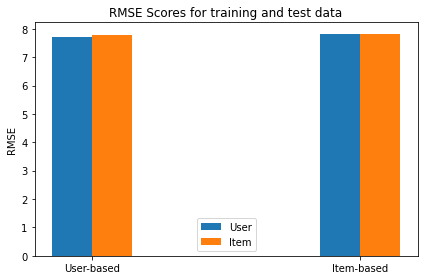

In [20]:
import matplotlib.pyplot as plt

labels = ['User-based', 'Item-based']
user_means = [train_user, test_user]
item_means = [train_item, test_item]

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, user_means, width, label='User')
rects2 = ax.bar(x + width/2, item_means, width, label='Item')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE Scores for training and test data')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


In [2]:
pip install surprise

Note: you may need to restart the kernel to use updated packages.


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [8]:
ratings.columns = ['User_ID', 'ISBN', 'Book_Rating']
users.columns = ['User_ID', 'Location', 'Age']
books.columns = ['ISBN', 'Book_Title', 'Book_Author', 'Year_Of_Publication', 'Publisher']


In [9]:
from surprise import KNNBasic
import heapq
from collections import defaultdict
from operator import itemgetter
from sortedcontainers import SortedList
from utils import *

from BookData import BookDataSet
from EvaluationData import CreateDataSets
from EvaluatedAlgorithm import EvaluatedAlgorithm


class SimpleCollaborativeFiltering:
    """
    K-Nearest Neighbors Collaborative Filtering System
    
    Attributes:
        data (object): surprise Book Dataset object
        k (int): number of books to recommend 
        max_rating (float): max rating in dataset
    """

    def __init__(self, ratings, books, users, k=10, max_rating=10.0):
        """
        Args:
            ratings (pandas df): ratings dataframe 
            books (pandas df): book information dataframe 
            users (pandas df): user information dataframe
            k (int): number of books to recommend 
            max_rating (float): max rating in dataset
        """
        self.data = BookDataSet(ratings, books, users)
        self.k = k
        self.max_rating = max_rating
        
    def get_neighbors(self, user_id, user_based_=True, metric='cosine', verbose=False):
        """
        Trains a model based on user based CF or item based CF
        Computes interation matrix and returns matrix and rows correspoonding with the user 
        Args:
            user_id (int): user id 
            user_based_ (boolean): use user based CF (True) or item based CF (False)
            metric (str): similarity metric 
            verbose (boolean): print output 
        Returns:
            interations (surprise matrix): similarity matrix 
            similarity_rows (list): user rows 
        """
        # create model
        self.train = self.data.build_full_trainset()
        sim_options = {'name': metric,
                       'user_based': user_based_
        }
        model = KNNBasic(sim_options=sim_options, verbose=verbose)
        model.fit(self.train)
        interations = model.compute_similarities()

        self.surprise_user_id = self.train.to_inner_uid(user_id)
        similarity_rows = interations[self.surprise_user_id]
        return interations, similarity_rows

    def show_top_books(self, candidates, watched_list):
        """
        Prints out top K books and corresponding score 
        Args:
            candidates (defaultdict): book id and score ({book_id:score})
            watched_list (list): list of books that the user has already seen
        """
        # print out top 10 books and score 
        N = 0
        print('Top {} Book Recommendations:'.format(self.k))
        print('\n')
        for item_id, ratings in sorted(candidates.items(), key=itemgetter(1), reverse=True):
            if item_id not in watched_list:
                book_id = self.train.to_raw_iid(item_id)
                book_name = self.data.get_book_name(book_id)
                book_author = self.data.get_book_author(book_id)
                book_year = self.data.get_book_year(book_id)
                try:
                    book_year = int(book_year) 
                except:
                    book_year = 'Not Available'
                print('{} - {} - ({}) - Score: {}'.format(book_name, book_author, book_year, round(ratings, 2)))
                N += 1
                if (N > self.k): break
        
    def user_based(self, user_id, threshold=False):
        """
        User based Collaborative Filtering 
        Args:
            user_id (int): user id 
            threshold (boolean): only use similar users above .95 correlation
        """
        _, similarity_rows = self.get_neighbors(user_id)
        
        similar_users = SortedList(key=lambda x: -x[1])
        for i, score in enumerate(similarity_rows):
            if i != user_id:
                similar_users.add((i, score))
        
        if threshold:
            similar_users = [rating for rating in similar_users if rating[1] >= 0.95]

        candidates = defaultdict(float)
        for similar_user in similar_users[:self.k]:
            surprise_sim_user_idx, score = similar_user
            sim_user_rating = self.train.ur[surprise_sim_user_idx]
            for info in sim_user_rating:
                book_id, rating = info
                # use += and increase weight for books that appear more than once 
                candidates[book_id] += (rating / self.max_rating) * score

        # list of books that the user has seen
        watched_list = [book_id for book_id, rating in self.train.ur[self.surprise_user_id]]

        # Get top-rated items from similar users
        self.show_top_books(candidates, watched_list)
        
    def item_based(self, user_id, threshold=False):
        """
        Item based Collaborative Filtering 
        Args:
            user_id (int): user id 
            threshold (boolean): only use similar users above .95 correlation
        """
        interations, _ = self.get_neighbors(user_id, user_based_=False)

        # Get the top K items we rated
        test_user_ratings = self.train.ur[self.surprise_user_id]

        if threshold:
            kNeighbors = [rating for rating in test_user_ratings if rating[1] >= 7.0]
        else:
            kNeighbors = heapq.nlargest(self.k, test_user_ratings, key=lambda t: t[1])
        
        # Get similar items to stuff we liked (weighted by rating)
        candidates = defaultdict(float)
        for item_id, rating in kNeighbors:
            similarity_row = interations[item_id]
            for inner_id, score in enumerate(similarity_row):
                candidates[inner_id] += score * (rating / 10.0)

        # list of books that the user has seen
        watched_list = [book_id for book_id, rating in self.train.ur[self.surprise_user_id]]
        
        # Get top-rated items from similar items
        self.show_top_books(candidates, watched_list)


In [29]:
# sample user (this user seems to like action and exciting books )
# 234828, 89602, 69697
USER_ID = 69697
books[books.ISBN.isin(ratings.loc[(ratings.User_ID == USER_ID) & (ratings.Book_Rating > 8), 'ISBN'])].head()

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher
1289,0553296981,Anne Frank The Diary of a Young Girl,ANNE FRANK,1993,Bantam
2038,0515131091,Out of This World,J D Robb,2001,Jove Books
2084,0373273193,Racing Against Time Cavanaugh Justice Intim...,Marie Ferrarella,2003,Silhouette
3077,0671003518,The BRIDE PROMOTIONAL,Julie Garwood,1996,Pocket
3159,0671034065,Mr Perfect,Linda Howard,2000,Atria


In [30]:
sample_ratings = popular_ratings(ratings, user_threshold=200, rating_threshold=200, book_threshold=1)
print('Sample Ratings Shape', sample_ratings.shape)
book_ratings = sample_ratings.pivot_table(index='User_ID', columns='ISBN', values='Book_Rating').fillna(0)
book_ratings.head()

Sample Ratings Shape (396585, 3)


ISBN,0375404120,9022906116,000000000,0000000000,00000000000,0000000029841,000104799X,0001048082,0001052276,0001056107,...,B000133Q02,B00016560C,B0001GMSV2,CARD#6920006,CN102273,CN108081,FUNNYSAUCE,O316666343,O67174142X,O77O428452
User_ID,,,,,,,,,,,,,,,,,,,,,
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# create k-Nearest Neighbors Collaborative Filtering model 
cf = SimpleCollaborativeFiltering(sample_ratings, books, users)

In [32]:
# k-Nearest Neighbors user based collaborative filtering 
cf.user_based(user_id=USER_ID)

Top 10 Book Recommendations:


Harry Potter and the Chamber of Secrets  Book 2  - J  K  Rowling - (2000) - Score: 0.45
The Devil You Know - Poppy Z  Brite - (2003) - Score: 0.45
Short  amp  Tall Tales  Moose County Legends Collected by James Mackintosh Qwilleran - Lilian Jackson Braun - (2002) - Score: 0.4
Politically Correct Bedtime Stories  Modern Tales for Our Life and Times - James Finn Garner - (1994) - Score: 0.0
Vegetarian Times Complete Cookbook - Lucy  Moll - (1995) - Score: 0.0
On Writing Well  25th Anniversary   The Classic Guide to Writing Nonfiction  On Writing Well  - William Zinsser - (2001) - Score: 0.0
The World of Jeeves - P G  Wodehouse - (1989) - Score: 0.0
 -  - (Not Available) - Score: 0.0
Beauty Fades  Dumb Is Forever  The Making of a Happy Woman - Judy Sheindlin - (1999) - Score: 0.0
In Country RI - Bobbie Ann Mason - (1986) - Score: 0.0
A Tree Grows in Brooklyn - Betty Smith - (1998) - Score: 0.0


In [33]:
# sample user (this user seems to like action and exciting books )
# 234828, 89602, 69697
USER_ID = 234828
books[books.ISBN.isin(ratings.loc[(ratings.User_ID == USER_ID) & (ratings.Book_Rating > 8), 'ISBN'])].head()

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher
66,042511774X,Breathing Lessons,Anne Tyler,1994,Berkley Publishing Group
1173,0345370775,Jurassic Park,Michael Crichton,1999,Ballantine Books
1463,0451191153,The Fountainhead,Ayn Rand,1996,New American Library
1815,0345380371,Rising Sun,MICHAEL CRICHTON,1992,Ballantine Books
1926,0553343874,Emmanuel s Book A Manual for Living Comfortab...,Pat Rodegast,1987,Bantam


In [34]:
# create k-Nearest Neighbors Collaborative Filtering model 
cf = SimpleCollaborativeFiltering(sample_ratings, books, users)

In [ ]:
# k-Nearest Neighbors item based collaborative filtering 
cf.item_based(user_id=USER_ID)

# SVD based Recommendation

In [10]:
ratings_explicit = df[df['Book-Rating'] != 0]
ratings_implicit = df[df['Book-Rating'] == 0]

In [11]:
ratings_explicit = ratings_explicit[['User-ID', 'ISBN', 'Book-Rating']]

In [12]:
ratings_explicit

,User-ID,ISBN,Book-Rating
1,2313,034545104X,5
2,6543,034545104X,5
3,8680,034545104X,5
4,10314,034545104X,9
5,23768,034545104X,9
...,...,...,...
883074,276688,0425150526,5
883075,276688,0449907422,5
883076,276690,0590907301,5
883077,276704,0679752714,5


In [13]:
from surprise import Reader, Dataset

# Creating a 'Reader' object to set the limit of the ratings 

reader = Reader(rating_scale=(1, 10))

data = Dataset.load_from_df(ratings_explicit, reader)

In [14]:
from surprise import SVD, model_selection, accuracy
from surprise.model_selection import cross_validate

model = SVD()

# Train on books dataset

xyz = cross_validate(model, data, measures=['RMSE','MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.7048  1.7093  1.7147  1.7120  1.7164  1.7114  0.0041  
MAE (testset)     1.3500  1.3527  1.3559  1.3555  1.3594  1.3547  0.0032  
Fit time          41.41   42.54   41.67   42.05   40.97   41.73   0.54    
Test time         1.24    1.48    1.23    1.15    1.20    1.26    0.11    


In [15]:
svd_Rmse = xyz.get('test_rmse')
svd_Mae = xyz.get('test_mae')

In [18]:
svd_Rmse, svd_Mae

(array([1.70476948, 1.70927577, 1.71466049, 1.71198239, 1.71640697]),
 array([1.34995576, 1.35267569, 1.35586214, 1.35546208, 1.35938505]))

In [24]:
#split the data into train and test sets
trainset, testset = model_selection.train_test_split(data, test_size=0.2)

# model1 = NMF()
model.fit(trainset)

#Tested model and found the predictions
predictions = model.test(testset)

#Calculated RMSE score
accuracy.rmse(predictions)

RMSE: 1.7100


1.7099572856268443

In [20]:
from surprise import NMF
#Create NMF model to cpmare with SVD
model1 = NMF()

# Train on books dataset
nmfData = cross_validate(model1, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.3756  2.3791  2.3794  2.3653  2.3638  2.3726  0.0067  
MAE (testset)     2.0132  2.0174  2.0176  2.0042  2.0026  2.0110  0.0064  
Fit time          58.07   58.64   59.15   59.11   58.06   58.60   0.48    
Test time         1.27    1.19    1.26    1.25    1.20    1.23    0.03    


In [21]:
nmfRmse = nmfData.get('test_rmse')
nmfMae = nmfData.get('test_mae')

In [22]:
nmfRmse, nmfMae

(array([2.37558605, 2.37909268, 2.37937566, 2.36527581, 2.3638154 ]),
 array([2.01322949, 2.01743113, 2.01755329, 2.00419249, 2.00256438]))

In [23]:
#split the data into train and test sets
trainset, testset = model_selection.train_test_split(data, test_size=0.2)

# model1 = NMF()
model1.fit(trainset)

#Tested model and found the predictions
predictions = model1.test(testset)

#Calculated RMSE score
accuracy.rmse(predictions)

RMSE: 2.3865


2.386536323362893

# Content Based Recommender

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re


def clean_fields(x, combine=False):
    """clean string field"""
    x = x.lower()
    x = re.sub('[^a-z0-9 ]', '', x)
    if combine:
        return ''.join(x.replace(' ', '') for x in x).strip()
    return x.strip()

# sort and return top
def sort_sims(sim_scores, topN=10):
    """sort scores by value of dict and return topN results"""
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    return sim_scores[:topN+1]
        


class ContentBased(object):
    """
    Content Based Filtering

    Attributes:
        ratings (pandas df): ratings dataframe 
        books (pandas df): book information dataframe 
        cosine_sim (sparse matrix): cosine similarity matrix
        indices (pandas df): Book Title Series 
    """
    def __init__(self, ratings, books):
        """
        Args:
            ratings (pandas df): ratings dataframe 
            books (pandas df): book information dataframe 
        """
        self.ratings = ratings
        books = self.prepare_data(books, ratings)
        self.cosine_sim, self.books, self.indices = self.compute_similarity(books)
        
    def prepare_data(self, books, ratings, rating_threshold=2):
        """
        Cleans and subsets book dataframe
        Args:
            ratings (pandas df): ratings dataframe 
            books (pandas df): book information dataframe
            rating_threshold (int): threshold to limit rating count 
        Returns:
            books (pandas df): book information dataframe 
        """
        books = books[books['ISBN'].isin(ratings['ISBN'])]
        books = books.drop_duplicates(subset=['Book-Title'])
        most_popular_ISBN = list(ratings['ISBN'].value_counts()[ratings['ISBN'].value_counts() >= rating_threshold].index)
        books = books[books.ISBN.isin(most_popular_ISBN)]
        books['Publisher'] = books['Publisher'].map(lambda x: clean_fields(x, combine=True))
        books['Book-Author'] = books['Book-Author'].map(lambda x: clean_fields(x, combine=True))
        books['Book-Title-Clean'] = books['Book-Title'].map(lambda x: clean_fields(x, combine=False))
        books['soup'] = books['Book-Title-Clean'] + ' ' + books['Book-Author'] + ' ' + books['Publisher']
        return books 
        
    def compute_similarity(self, books):
        """
        Creates BOW model on the combined book text fields and computes similarity
        Args:
            books (pandas df): book information dataframe
        Returns:
            books (pandas df): book information dataframe 
            cosine_sim (sparse matrix): cosine similarity matrix
            indices (pandas df): Book Title Series  
        """
        vect = CountVectorizer(stop_words='english', max_features=1000)
        count_matrix = vect.fit_transform(books['soup'])
        cosine_sim = cosine_similarity(count_matrix, count_matrix)
        books = books.reset_index()
        indices = pd.Series(books.index, index=books['Book-Title']).drop_duplicates()
        return cosine_sim, books, indices
    
    def compute_year_similarity(self, book1, book2, value=10):
        """
        Computes similarity score based on year with exponential decay 
        Args:
            book1 (int): year of book1
            book2 (int): year of book2
        Returns:
            sim (int): similarity score
        """
        diff = abs(book1 - book2)
        sim = np.exp(-int(diff) / value)
        return sim
        
    def get_recommendations(self, title, topN=10):
        """
        Generate recommendations based on cosine similarity and year similarity based on similar books
        Return topN similar Book Titles 
        Args:
            title (str): Book Title to use for comparison
            topN (int): how many similar books to recommend 
        Returns:
            indices (pandas df): Top N most similar books to passed in book 
        """
        # Get the index of the book that matches the title
        idx = self.indices[title]
        year = self.books['Year-Of-Publication'] [self.books['Book-Title'] == title]
        if isinstance(idx, pd.Series):
            idx = idx.iloc[0]
            year = year.iloc[0]
        # Get the pairwsie similarity scores of all books with that book
        sim_scores = list(enumerate(self.cosine_sim[idx]))
        sim_scores = sort_sims(sim_scores, topN=50)

        # Get the book indices
        book_indices = [i[0] for i in sim_scores]
        year_scores = self.books['Year-Of-Publication'].iloc[book_indices].map(lambda x: self.compute_year_similarity(x, year)).values
        # multiply vect scores with year scores 
        final_scores = list(zip(book_indices, np.array([i[1] for i in sim_scores]) * year_scores))
        sim_scores = sort_sims(sim_scores, topN=topN)

        # remove current title
        book_indices = []
        for i, _ in sim_scores:
            if i != idx:
                book_indices.append(i)
                

        # Return the top N most similar books
        return self.books['Book-Title'].iloc[book_indices]

In [4]:
# Create model 
content_rec = ContentBased(ratings, books)

In [11]:
# Most similar books to The Hobbit
content_rec.get_recommendations("Degree of Guilt")

19                           Airframe
20                           Timeline
60                         Seabiscuit
174                             Congo
175                Protect and Defend
176               The Tall Pine Polka
283          Dave Barry in Cyberspace
417                      Househusband
512    The Mummy or Ramses the Damned
611              My Name Is Asher Lev
Name: Book-Title, dtype: object

# Hybrid Recommenders

In [18]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re


def clean_fields(x, combine=False):
    """clean string field"""
    x = x.lower()
    x = re.sub('[^a-z0-9 ]', '', x)
    if combine:
        return ''.join(x.replace(' ', '') for x in x).strip()
    return x.strip()

# sort and return top
def sort_sims(sim_scores, topN=10):
    """sort scores by value of dict and return topN results"""
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    return sim_scores[:topN+1]
        


class Hybrid(object):
    """
    Content Based Filtering

    Attributes:
        ratings (pandas df): ratings dataframe 
        books (pandas df): book information dataframe 
        cosine_sim (sparse matrix): cosine similarity matrix
        indices (pandas df): Book Title Series 
    """
    def __init__(self, ratings, books):
        """
        Args:
            ratings (pandas df): ratings dataframe 
            books (pandas df): book information dataframe 
        """
        self.ratings = ratings
        books = self.prepare_data(books, ratings)
        self.cosine_sim, self.books, self.indices = self.compute_similarity(books)
        
    def getdata(self):
        return self.userId
    
    def prepare_data(self, books, ratings, rating_threshold=2):
        """
        Cleans and subsets book dataframe
        Args:
            ratings (pandas df): ratings dataframe 
            books (pandas df): book information dataframe
            rating_threshold (int): threshold to limit rating count 
        Returns:
            books (pandas df): book information dataframe 
        """
        books = books[books['ISBN'].isin(ratings['ISBN'])]
        books = books.drop_duplicates(subset=['Book-Title'])
        most_popular_ISBN = list(ratings['ISBN'].value_counts()[ratings['ISBN'].value_counts() >= rating_threshold].index)
        books = books[books.ISBN.isin(most_popular_ISBN)]
        books['Publisher'] = books['Publisher'].map(lambda x: clean_fields(x, combine=True))
        books['Book-Author'] = books['Book-Author'].map(lambda x: clean_fields(x, combine=True))
        books['Book-Title-Clean'] = books['Book-Title'].map(lambda x: clean_fields(x, combine=False))
        books['soup'] = books['Book-Title-Clean'] + ' ' + books['Book-Author'] + ' ' + books['Publisher']
        return books 
        
    def compute_similarity(self, books):
        """
        Creates BOW model on the combined book text fields and computes similarity
        Args:
            books (pandas df): book information dataframe
        Returns:
            books (pandas df): book information dataframe 
            cosine_sim (sparse matrix): cosine similarity matrix
            indices (pandas df): Book Title Series  
        """
        vect = CountVectorizer(stop_words='english', max_features=1000)
        count_matrix = vect.fit_transform(books['soup'])
        cosine_sim = cosine_similarity(count_matrix, count_matrix)
        books = books.reset_index()
        indices = pd.Series(books.index, index=books['Book-Title']).drop_duplicates()
        return cosine_sim, books, indices
    
    def compute_year_similarity(self, book1, book2, value=10):
        """
        Computes similarity score based on year with exponential decay 
        Args:
            book1 (int): year of book1
            book2 (int): year of book2
        Returns:
            sim (int): similarity score
        """
        diff = abs(book1 - book2)
        sim = np.exp(-int(diff) / value)
        return sim
        
    def get_recommendations(self, userId, title):
        """
        Generate recommendations based on cosine similarity and year similarity based on similar books
        Return topN similar Book Titles 
        Args:
            title (str): Book Title to use for comparison
            topN (int): how many similar books to recommend 
        Returns:
            indices (pandas df): Top N most similar books to passed in book 
        """
        # Get the index of the book that matches the title
        idx = self.indices[title]
        year = self.books['Year-Of-Publication'] [self.books['Book-Title'] == title]
        if isinstance(idx, pd.Series):
            idx = idx.iloc[0]
            year = year.iloc[0]
        # Get the pairwsie similarity scores of all books with that book
        sim_scores = list(enumerate(self.cosine_sim[idx]))
        sim_scores = sort_sims(sim_scores, topN=50)

        # Get the book indices
        book_indices = [i[0] for i in sim_scores]
        self.books = self.books.iloc[book_indices][['Book-Title', 'Book-Author', 'Year-Of-Publication']]

        #Compute the predicted ratings using the SVD filter
        self.books['est'] = self.books['Book-Title'].apply(lambda x: model.predict(userId, id_to_title.loc[x]['ISBN']).est)
    
        #Sort the movies in decreasing order of predicted rating
        self.books = self.books.sort_values('est', ascending=False)
    
        #Return the top 10 movies as recommendations
        return self.books.head(10)

In [ ]:
# Create model 
hybrid_rec = Hybrid(ratings, books)

In [ ]:
hybrid_rec.get_recommendations(1, 'The Hobbit')